In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime

from summer.utils import ref_times_to_dti

from autumn.tools.plots.utils import REF_DATE
from autumn.tools.runs import ManagedRun
from autumn.tools.runs.calibration.utils import get_posteriors
from autumn.tools.utils.pandas import pdfilt
from autumn.settings.region import Region

## Specify the runs of interest

In [2]:
run_id = "sm_sir/bangladesh/1648429091/e3fd761"

In [3]:
mr = ManagedRun(run_id)

In [11]:
full_run = mr.full_run.get_derived_outputs()
pbi = mr.powerbi.get_db()
targets = pbi.get_targets()
results = pbi.get_uncertainty()
mcmc_params = mr.calibration.get_mcmc_params()

## Calibration parameters are:

In [19]:
list(mcmc_params.columns)

['contact_rate',
 'testing_to_detection.assumed_cdr_parameter',
 'voc_emergence.omicron.contact_rate_multiplier',
 'voc_emergence.omicron.new_voc_seed.start_time']

IndexError: index 4 is out of bounds for axis 0 with size 4

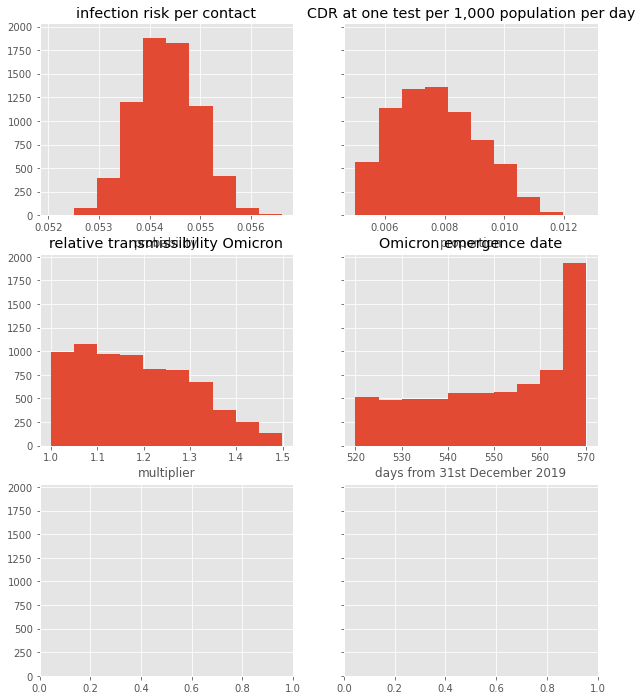

In [22]:
plt.style.use("ggplot")

param_lookup = {
    "contact_rate": "infection risk per contact",
    "testing_to_detection.assumed_cdr_parameter": "CDR at one test per 1,000 population per day",
    "voc_emergence.omicron.new_voc_seed.start_time": "Omicron emergence date",
    "voc_emergence.omicron.contact_rate_multiplier": "relative transmissibility Omicron",
    "age_stratification.cfr.multiplier": "modification to fatality rate",
    "age_stratification.prop_hospital.multiplier": "modification to hospitalisation rate",
}

unit_lookup = {
    "contact_rate": "probability",
    "testing_to_detection.assumed_cdr_parameter": "proportion",
    "voc_emergence.omicron.new_voc_seed.start_time": "days from 31st December 2019",
    "voc_emergence.omicron.contact_rate_multiplier": "multiplier",
    "age_stratification.cfr.multiplier": "multiplier",
    "age_stratification.prop_hospital.multiplier": "multiplier",
}

fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharey="all")
for i_ax, axis in enumerate(axes.reshape(-1)):
    param = mcmc_params.columns[i_ax]
    axis.hist(mcmc_params[param])
    axis.set_title(param_lookup[param])
    axis.set_xlabel(unit_lookup[param])
fig.suptitle("parameter posterior histograms", fontsize=15, y=1)
fig.tight_layout()

## Available model outputs are:

In [14]:
[col for col in full_run.columns if "X" not in col]

['chain',
 'run',
 'scenario',
 'times',
 'ever_infected',
 'ever_detected_incidence',
 'notifications',
 'infection_deaths',
 'icu_admissions',
 'icu_occupancy',
 'hospital_admissions',
 'hospital_occupancy',
 'incidence',
 'cdr',
 'total_population',
 'prop_ever_infected']

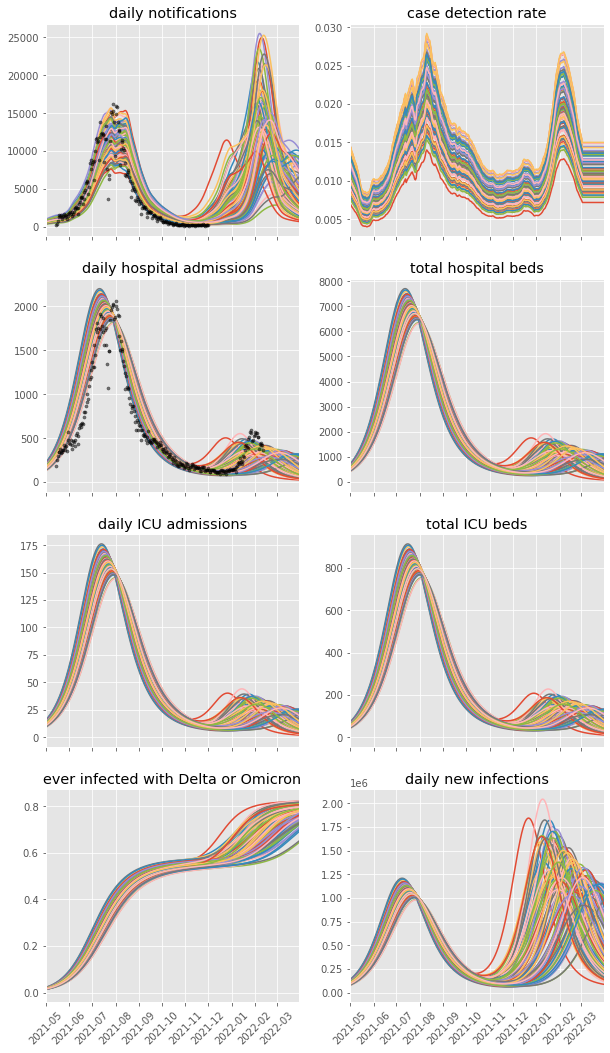

In [23]:
title_lookup = {
    "notifications": "daily notifications",
    "infection_deaths": "COVID-19-specific deaths",
    "hospital_admissions": "new daily hospital admissions",
    "icu_admissions": "new daily admissions to ICU",
    "proportion_seropositive": "proportion recovered from COVID-19",
    "incidence": "daily new infections",
    "prop_incidence_strain_delta": "proportion of cases due to Delta",
    "hospital_admissions": "daily hospital admissions",
    "hospital_occupancy": "total hospital beds",
    "icu_admissions": "daily ICU admissions",
    "icu_occupancy": "total ICU beds",
    "prop_ever_infected": "ever infected with Delta or Omicron",
    "cdr": "case detection rate",
}

fig, axes = plt.subplots(4, 2, figsize=(10, 18), sharex="all")
plot_left_date = datetime.date(2021, 5, 1)
plot_right_date = datetime.date(2022, 3, 31)
outputs = (
    "notifications", 
    "cdr",
    "hospital_admissions",
    "hospital_occupancy",
    "icu_admissions", 
    "icu_occupancy",
    "prop_ever_infected",
    "incidence",
)
for i_ax, axis in enumerate(axes.reshape(-1)):
    output = outputs[i_ax]
    scenario_chain = (full_run["scenario"] == 0) & (full_run["chain"] == 0)
    for i_run in full_run[scenario_chain]["run"].unique():
        selection = full_run[(full_run["run"] == i_run) & scenario_chain]
        axis.plot(ref_times_to_dti(REF_DATE, selection["times"]), selection[output])
    if output in targets:
        axis.scatter(targets.index, targets[output], color="k", s=10, alpha=0.5, zorder=10)
    axis.tick_params(axis="x", labelrotation=45)
    axis.set_title(title_lookup[output])
    axis.set_xlim(left=plot_left_date, right=plot_right_date)

In [16]:
def plot_outputs(outputs, left_date, right_date):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex="all")
    colour = (0.2, 0.2, 0.8)
    for i_ax, axis in enumerate(axes.reshape(-1)):
        output = outputs[i_ax]
        results_df = results[(output, 0)]
        indices = results_df.index
        axis.fill_between(indices, results_df[0.025], results_df[0.975], color=colour, alpha=0.5)
        axis.fill_between(indices, results_df[0.25], results_df[0.75], color=colour, alpha=0.7)
        axis.plot(indices, results_df[0.500], color="b")
        if output in targets:
            axis.scatter(targets.index, targets[output], color="k", alpha=0.5, s=10)
        axis.tick_params(axis="x", labelrotation=45)
        axis.set_xlim(left=left_date, right=right_date)
        axis.set_title(title_lookup[output])
    fig.tight_layout()

IndexError: tuple index out of range

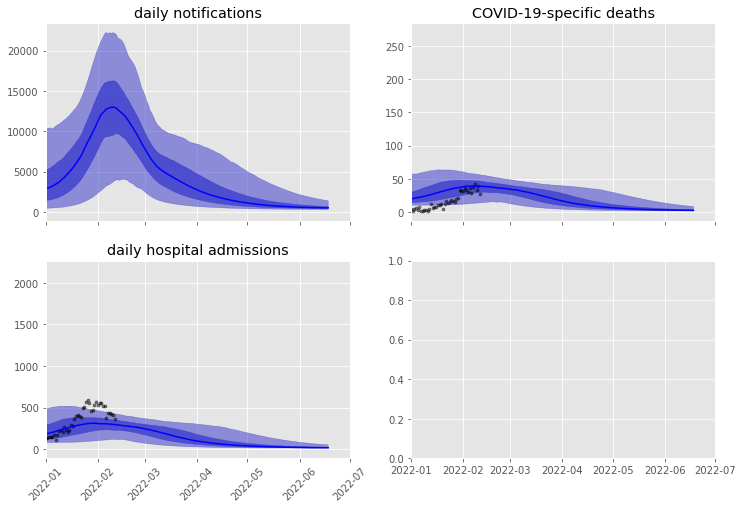

In [17]:
left_date = datetime.date(2022, 1, 1)
right_date = datetime.date(2022, 7, 1)
outputs_to_plot = (
    "notifications", 
    "infection_deaths",
    "hospital_admissions",
#     "icu_occupancy",
)
plot_outputs(outputs_to_plot, left_date, right_date)